<a href="https://colab.research.google.com/github/FrancoiseArtignan/VDB_jupyter/blob/tp2_Francoise/TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Objectifs
##### 1 Lire et traiter des données d'entrée avec [PANDAS](https://pandas.pydata.org/)

##### 2 Représenter la distribution empirique des "fold-change" (**FC**) vs Précision, aka: volcano-plot
    
##### 3 Effectuer une analyse de sur-représentation en termes GO


## Ressources : Rappels et illustration de l'analyse de représentation de termes GO
###### [TP de MADP](https://github.com/glaunay/tp-proteomics#3-obtention-des-param%C3%A8tres-du-mod%C3%A8le)
###### [Fiche Bioconductor](https://www.bioconductor.org/help/course-materials/2015/SeattleApr2015/E_GeneSetEnrichment.html)



In [101]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Préparation de  l'environnement

##### Please `pip install -r requirements.txt` first

##### Directory Configuration

* `workDir` points to the Git project, holds the *tsv* file
* `libDir` points to Git project subdirectory hosting python library with files names `go.py  stat_utils.py  uniprot.py`
* `dataDir` points to the data folder with uniprot and GO files

In [ ]:
!pip install biopython

In [ ]:
!pip install pyproteinsExt==1.5

In [ ]:
!pip install owlready2

In [ ]:
!pip install pyproteins==1.5

In [107]:
import sys, os
workDir = f"{os.getcwd()}/.."
libDir = f"{workDir}/content/drive/MyDrive/M2-2022-2023/VDB/VDB_jupyter/lib"
dataDir= f"{workDir}/content/drive/MyDrive/M2-2022-2023/VDB/VDB_jupyter/data" 

sys.path.append(libDir)

In [ ]:
%load_ext autoreload
%autoreload 2

In [109]:
import pandas as pd
import numpy as np

In [110]:
%matplotlib inline
import matplotlib.pyplot as plt

## Jeux de données
* Jeux de données de protéomique quantitative au format TSV
* Ontologie GO au format [owl](http://www.obofoundry.org/ontology/go.html)
* Entrées Uniprot au format XML
    * Protéines de l'étude
    * Protéome d'E.Coli complet
    
<hr style="border:1px solid gray"> </hr>

### Lecture des valeurs experimentales
Charger ```TCL_wt1.tsv``` dans une [dataframe pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ 
Retirer les lignes présentant des aberrations numériques
</span>
<br/><span style="color:firebrick;font-weight:bold">$\rhd$ Attention aux types des colonnes !</span>

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/M2-2022-2023/VDB/VDB_jupyter/TCL_wt1.tsv",sep = '\t', na_values="#VALEUR!", 
                   dtype = {'Accession': str, 'Description': str, 'Gene Symbol': str, 
                            'Corrected Abundance ratio (1.53)': np.float,  
                            'Log2 Corrected Abundance Ratio': np.float,  
                            'Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT)': np.float, 
                            '-LOG10 Adj.P-val': np.float})
data = data.copy()
data = data.dropna()

In [138]:
#index_with_nan = data.index[data.isnull().any(axis=1)]
#data.drop(index_with_nan, 0, inplace=True)

new_data = data[ (data['Log2 Corrected Abundance Ratio'] != '#VALEUR!') & (data['LOG10 Adj.P-val'] != '#VALEUR!')]
new_data.loc[:,'Log2 Corrected Abundance Ratio'] = new_data.loc[:,'Log2 Corrected Abundance Ratio'].astype(float)
new_data.head(10)


,Accession,Description,Gene Symbol,Corrected Abundance ratio (1.53),Log2 Corrected Abundance Ratio,Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT),LOG10 Adj.P-val
0,P75936,Basal-body rod modification protein FlgD OS=Es...,flgD,0.075817,-3.721335,5.494560e-05,4.260067
1,P76231,Uncharacterized protein YeaC OS=Escherichia co...,yeaC,0.092810,-3.429569,3.510530e-04,3.454627
2,P0A8S9,Flagellar transcriptional regulator FlhD OS=Es...,flhD,0.102614,-3.284695,2.679790e-05,4.571899
4,P05706,PTS system glucitol/sorbitol-specific EIIA com...,srlB,0.108497,-3.204277,1.996330e-02,1.699768
5,P29744,Flagellar hook-associated protein 3 OS=Escheri...,flgL,0.124183,-3.009460,3.674628e-02,1.434787
6,P0A9A2,Bacterial non-heme ferritin-like protein OS=Es...,ftnB,0.126797,-2.979403,1.296589e-03,2.887198
7,P75937,Flagellar hook protein FlgE OS=Escherichia col...,flgE,0.137908,-2.858217,7.012880e-07,6.154104
8,P43533,Flagella synthesis protein FlgN OS=Escherichia...,flgN,0.150327,-2.733826,1.322797e-03,2.878507
9,P0ABR1,DNA damage-inducible protein I OS=Escherichia ...,dinI,0.159477,-2.648579,4.689497e-01,0.328874
10,P26608,Flagellar secretion chaperone FliS OS=Escheric...,fliS,0.162092,-2.625120,5.282561e-01,0.277155


##### 1. Un premier volcano-plot

Ce type de figure représente pour chaque protéine en abscisse le taux d'abondance et en ordonnée la précision de la mesure.

<span style="color:firebrick;font-weight:bold">$\rhd$ 1. Réaliser un scatter plot matplotlib avec</span>
<br/><span style="color:firebrick;font-weight:bold">- en x, `Log2 Corrected Abundance Ratio`</span>
<br/><span style="color:firebrick;font-weight:bold">-  en y, `LOG10 Adj.P-val`</span>

<span style="color:firebrick;font-weight:bold">$\rhd$Vous légenderez les axes, attention `LOG10 Adj.P-val` est en fait `-LOG10 Adj.P-val`, regardez bien.</span>

1746
1746


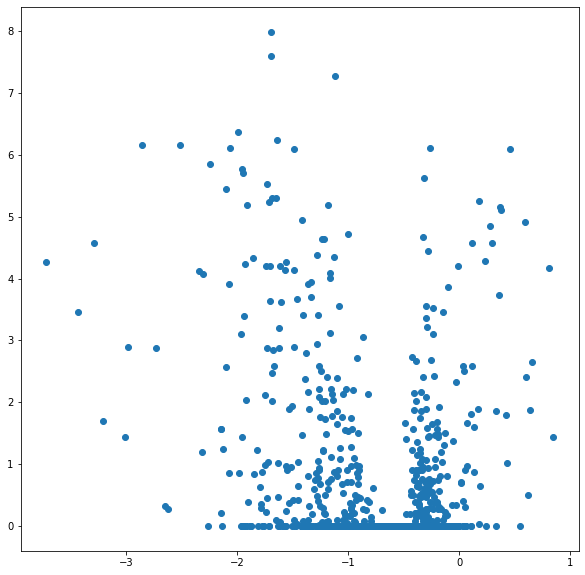

In [139]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(new_data['Log2 Corrected Abundance Ratio'], abs(new_data['LOG10 Adj.P-val']))
print(len(new_data['Log2 Corrected Abundance Ratio']))
print(len(abs(new_data['LOG10 Adj.P-val'])))


##### 2. Réaliser des versions évoluées du graphique précédent
L'objectif est de mettre l'accent sur la région **-Log10 adj Pvalue > 4** et **Log2 corrected abundance ratio > 0**.
<br/>Pour cela vous revisiterez le scatter plot précedent au travers des versions suivantes:
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ première version : un rectangle de la couleur de votre choix matérialisera la région</span>
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ deuxième version  : une couleur de votre choix représentera les points de la région</span>
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ troisème version (optionnel): Les identifiants uniprot remplaceront les points des protéines de la région</span>

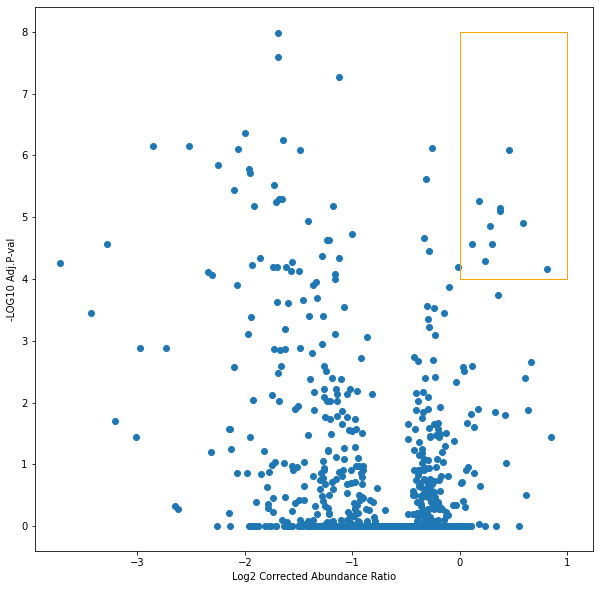

In [140]:
from matplotlib.patches import ArrowStyle
from matplotlib.patches import Rectangle

#1
fig, ax = plt.subplots(figsize=(10,10), ncols=1, nrows=1)
ax.scatter(new_data['Log2 Corrected Abundance Ratio'],new_data['LOG10 Adj.P-val'])
ax.set_xlabel("Log2 Corrected Abundance Ratio")
ax.set_ylabel("-LOG10 Adj.P-val")
ax.add_patch(Rectangle((0,4), 1,4,facecolor='none', edgecolor='orange'))

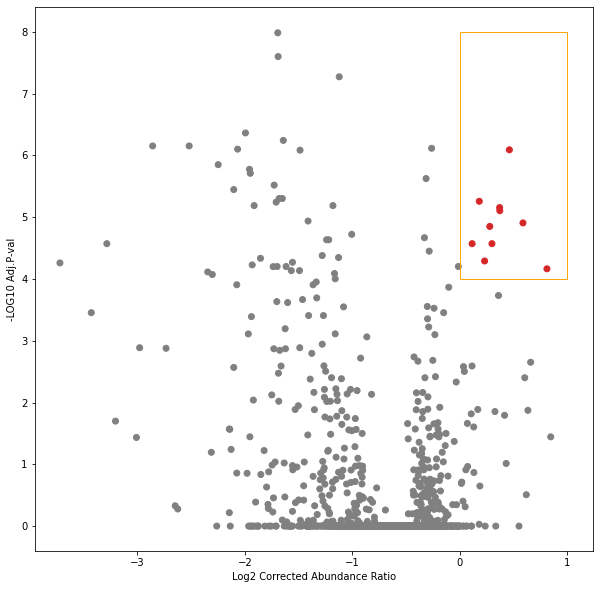

In [142]:
#2
fig2, ax2 = plt.subplots(figsize=(10,10), ncols=1, nrows=1)

ax2.set_xlabel("Log2 Corrected Abundance Ratio")
ax2.set_ylabel("-LOG10 Adj.P-val")
ax2.add_patch(Rectangle((0,4), 1,4,facecolor='none', edgecolor='orange'))
new_data['group'] = 'grey'
new_data.loc[(new_data['LOG10 Adj.P-val'] > 4 )  & (new_data['Log2 Corrected Abundance Ratio'] > 0.0 ),'group' ] = 'tab:red'
ax2.scatter(new_data['Log2 Corrected Abundance Ratio'],new_data['LOG10 Adj.P-val'], c=new_data['group'])

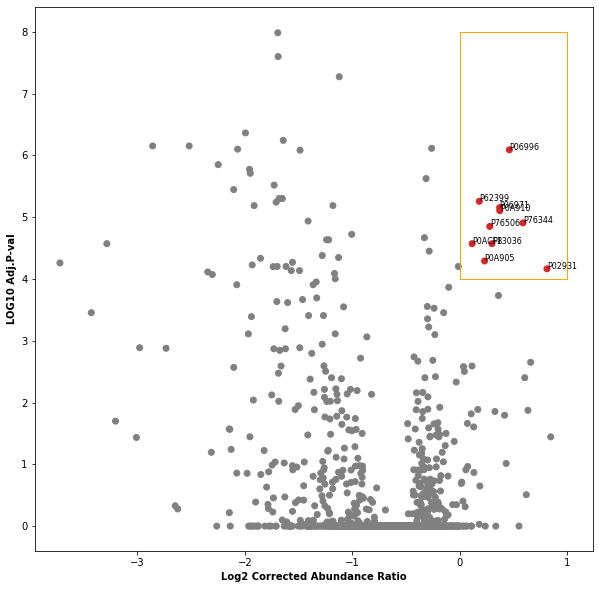

In [153]:
#3
new_data['x'] = new_data['Log2 Corrected Abundance Ratio']
new_data['y'] = new_data['LOG10 Adj.P-val']

fig3, ax3 = plt.subplots(figsize=(10,10), ncols=1, nrows=1)

ax3.set_xlabel('Log2 Corrected Abundance Ratio',fontweight='bold')
ax3.set_ylabel('LOG10 Adj.P-val',fontweight='bold')
ax3.add_patch(Rectangle((0,4), 1,4,facecolor='none', edgecolor='orange'))
new_data['group'] = 'grey'
new_data.loc[(new_data['y'] > 4 ) & (new_data['x'] > 0.0 ),'group' ] = 'tab:red'
#new_data.loc[(new_data['y'] < 4 )  & (new_data['x'] > 0.0 ),'group' ] = 'tab:blue'
ax3.scatter(new_data['x'],new_data['y'], c=new_data['group'])

texts = []
for i in range(len(new_data)):
  if (new_data.iloc[i].y>4) and (new_data.iloc[i].x>0):
    texts.append(plt.text(x = new_data.iloc[i].x, y = new_data.iloc[i].y, s=new_data.iloc[i].Accession, fontsize = 8))


#### Analyse ORA

##### Principes
Vous disposez d'un objet analyser permettant de réaliser une analyse de la sur-représentation (**ORA**) en termes GO parmi une liste de protéine d'intérêt.
La fréquence des termes GO dans le protéome totale est utilisée comme référence.

L'objet analyser s'instancie ainsi
```python
from stat_utils import GO_ORA_analyser
o = GO_ORA_analyser(f"{dataDir}/go.owl", f"{dataDir}/K12_proteome", f"{dataDir}/dataset")
```

Il fournit une méthode pour chaque catégorie de termes GO
<i>{ biological_process, molecular_function, cellular_component }</i>

Une éventuelle surreprésentation des termes GO de la catégorie <i>biological_process</i> est par exemple calculée parmi les protéines P29744 et P05706 de la façon suivante:

```python
goTerm_scores = o.biological_process(["P29744", "P05706"])
```
<span style="color:green;font-weight:bold">$\uparrow$ Reproduire cet exemple dans la cellule ci-dessous.$\downarrow$ </span>
</br><span style="color:firebrick;font-weight:bold"> $\rhd$ Inspecter l'objet retourné par la méthode o.biological_process, que voyez-vous ?</span>

In [ ]:
from stat_utils import GO_ORA_analyser
o = GO_ORA_analyser(f"{dataDir}/go.owl", f"{dataDir}/K12_proteome", f"{dataDir}/dataset")
#goTerm_scores = o.biological_process(["P29744", "P05706"])
#print(goTerm_scores)

###### 2/ Analyser la représentation des termes GO parmi les protéines surabondantes de l'experience
<span style="color:firebrick;font-weight:bold"> $\rhd$ Vous devrez extraire les identifiants uniprot des protéines aux `Log2 Corrected Abundance Ratio` supérieurs au seuil alpha de 5%.</span>
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ Vous conduirez sur cette liste de protéines une analyse de sur-représentation en termes GO à l'aide d'un objet *GO_ORA_analyser*.</span>
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ Vous pouvez faire varier le seuil d'abondance autour de la valeur alpha.</span>
<br/><span style="color:firebrick;font-weight:bold"> $\rhd$ Vous traiterez les 3 catégories *biological_process / molecular_function /cellular_component*.</span>



Familiarisez-vous avec la structures des dictionnaires de résultas, vous pouvez [les sauvegarder au format json](https://docs.python.org/3/library/json.html).


In [ ]:
# extraire les identifiants uniprot des protéines aux Log2 Corrected Abundance Ratio supérieurs au seuil alpha de 5%.
# sur cette liste de protéines une analyse de sur-représentation en termes GO à l'aide d'un objet GO_ORA_analyser.
# faire varier le seuil d'abondance autour de la valeur alpha (-0.099..-0.095..-0.091)
# 3 catégories biological_process / molecular_function /cellular_component

pv = -0.091
while pv > -0.099 :

    new_data=new_data.loc[new_data["Log2 Corrected Abundance Ratio"]> -0.095] #recuperation des id avec une abondance superieur à 5%
    
    #Analyse de "biological process"
    o = GO_ORA_analyser(f"{dataDir}/go.owl", f"{dataDir}/K12_proteome", f"{dataDir}/dataset")
    new_data_bp = o.biological_process(new_data['Accession'].values.tolist())
    
    #Analyse de "molecular function"
    o = GO_ORA_analyser(f"{dataDir}/go.owl", f"{dataDir}/K12_proteome", f"{dataDir}/dataset")
    new_data_mf = o.molecular_function(new_data['Accession'].values.tolist())
    
    #Analyse de "cellular component"
    o = GO_ORA_analyser(f"{dataDir}/go.owl", f"{dataDir}/K12_proteome", f"{dataDir}/dataset")
    new_data_cc = o.cellular_component(new_data['Accession'].values.tolist())
   
    pv -= 0.001

In [123]:
print(type(new_data_bp))
print(new_data_bp[0])
print(new_data_cc[0])
print(new_data_mf[0])

<class 'list'>
(2.4384924030882882e-05, 'siderophore transport', 'GO:0015891', ['P13036', 'P06971', 'P75780', 'P02930', 'P05825'])
(6.8944572288325495e-19, 'cell outer membrane', 'GO:0009279', ['P0A921', 'P0ADE4', 'P02943', 'P0A940', 'P09169', 'P05825', 'P0A915', 'P39180', 'P0A905', 'P76471', 'P76506', 'P13036', 'P0A927', 'P10384', 'P06971', 'P0A910', 'P0A908', 'P75780', 'P06996', 'P06129', 'P02930', 'P0A917', 'P02931', 'P0AB40', 'P0A921', 'P09169', 'P0A921', 'P0ADE4', 'P02943', 'P05825', 'P0A937', 'P06996', 'P0A903', 'P77774', 'P0A940', 'P0A937'])
(1.1519075123216585e-06, 'porin activity', 'GO:0015288', ['P02943', 'P0A910', 'P06996', 'P06129', 'P02930', 'P02931', 'P02943', 'P0A927', 'P10384'])


In [ ]:
# Familiarisez-vous avec la structures des dictionnaires de résultas, vous pouvez les sauvegarder au format json.
  
  

## Une première application: représentation riche du résultat de l'analyse


### Mise en forme "riche" des résultats grâce au notebook

Jupyter permet d'étendre le concept de la méthode **__str__()** afin de produire du contenu HTML.
 Ainsi, tout objet impémentant une méthode **_repr_html_()** sera affiché, via son rendu HTML, dans la cellule d'un notebook.

```python
class Point():
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
    def _repr_html_(self):
        htmlString = "<table><thead><tr><td>Abscisse</td><td>Ordonnée</td><td>Cote</td></tr></thead>"
        htmlString += f"<tbody><tr><td>{self.x}</td><td>{self.y}</td><td>{self.z}</td></tr></tbody></table>"
        return htmlString
Point(2,3,4)
```
Affichera

![caption](../figs/reprhtml.png)


### Intégration des résultats à la visualisation du notebook 

En vous inspirant de la fonction ci-dessus, implémenter une classe Rich_GO_ORA dont la méthode [`_repr_html_`](https://ipython.readthedocs.io/en/stable/config/integrating.html) permettra un affichage plus lisible d'une des analyses `biological_process / molecular_function /cellular_component`

Un exemple possible est,
![caption](../figs/_repr_html_.png)

(Bonus): clicker sur le nom du terme GO envoie vers sa description.
Pour cela, afficher le nom du pathway dans une balise hyperlien pour permettre d'acceder à la page de description du terme GO. 

Les termes GO sont accessibles aux URL de la forme
`http://amigo.geneontology.org/amigo/term/GO:GO_NUMBER`.




In [125]:
class GO():
  def __init__(self, go_list):
    self.go_list = go_list

  def _repr_html_(self):
    htmlString = "<table><thead><tr><td>p-value</td><td>Description</td><td>GO</td><td>number of id</td><td>id</td></tr></thead><tbody>"
    for line in self.go_list:
      
      htmlString += f"<tr><td>{line[0]}</td><td>{line[1]}</td><td>{line[2]}</td><td>{len(line[3])}</td><td>{line[3]}</td></tr>"
    htmlString += "</tbody></table>"
    return htmlString

GO(new_data_bp[:10])

p-value,Description,GO,number of id,id
2.4384924030882882e-05,siderophore transport,GO:0015891,5,"['P13036', 'P06971', 'P75780', 'P02930', 'P05825']"
5.5617663703120443e-05,ion transport,GO:0006811,22,"['P02943', 'P0A927', 'P0A910', 'P0AG78', 'P0AFJ5', 'P23173', 'P0AER8', 'P02930', 'P05825', 'P06996', 'P76506', 'P77338', 'P0AB98', 'P13036', 'P05825', 'P13036', 'P06971', 'P75780', 'P0A910', 'P06129', 'P02930', 'P02931']"
0.00010969835821254218,iron coordination entity transport,GO:1901678,6,"['P05825', 'P05825', 'P13036', 'P06971', 'P75780', 'P02930']"
0.00015176009449613747,protein insertion into membrane,GO:0051205,4,"['P0A903', 'P77774', 'P0A940', 'P0A937']"
0.0002376596372973482,membrane organization,GO:0061024,9,"['P0A903', 'P77774', 'P0A940', 'P0A937', 'P0A903', 'P77774', 'P0A940', 'P0A937', 'P76506']"
0.000267307498246767,Gram-negative-bacterium-type cell outer membrane assembly,GO:0043165,4,"['P0A903', 'P77774', 'P0A940', 'P0A937']"
0.000267307498246767,membrane assembly,GO:0071709,4,"['P0A903', 'P77774', 'P0A940', 'P0A937']"
0.0003440562569095823,establishment of protein localization to membrane,GO:0090150,4,"['P0A903', 'P77774', 'P0A940', 'P0A937']"
0.0009106481040636981,iron ion transport,GO:0006826,7,"['P13036', 'P05825', 'P05825', 'P13036', 'P06971', 'P75780', 'P02930']"
0.001029678690881575,establishment of localization,GO:0051234,36,"['P02943', 'P0A927', 'P0A910', 'P0AG78', 'P0AFJ5', 'P23173', 'P0AER8', 'P02930', 'P05825', 'P06996', 'P76506', 'P77338', 'P0AB98', 'P13036', 'P05825', 'P13036', 'P06971', 'P75780', 'P0A910', 'P06129', 'P02930', 'P02931', 'P77338', 'P0AGI1', 'P02931', 'P02943', 'P0ADE4', 'P05825', 'P75780', 'P0A927', 'P06129', 'P02930', 'P0A903', 'P77774', 'P0A940', 'P0A937']"


## Une deuxième application: volcano plot améliorés
###### PANDAS
En choisissant comme seuil la valeur `alpha` du TP précédent, veuillez extraires les identifiants uniprot des protéines sur-abondantes (rappel les valeurs d'abondance sont celles de la colonne `Log2 Corrected Abundance Ratio`).

Vous devrez avoir dans des listes distinctes:
* identifiants uniprot
* `Log2 Corrected Abundance Ratio`
* `LOG10 Adj.P-val'`

###### Représentation graphiques
* Pour la catégorie de termes GO (biological_process / molecular_function /cellular_component) de votre choix
    * Générer une grille de 4 graphiques 
    * Dans chaque graphique colorez dans une couleur différentes les protéines porteuses de 4 termes de GO que vous estimez les plus pertinents 
    * Donnez le nom de la catégorie générale à la grille
    * Donnez le nom du terme GO représenté dans chaque graphique avec une couleur de titre cohérente.
    

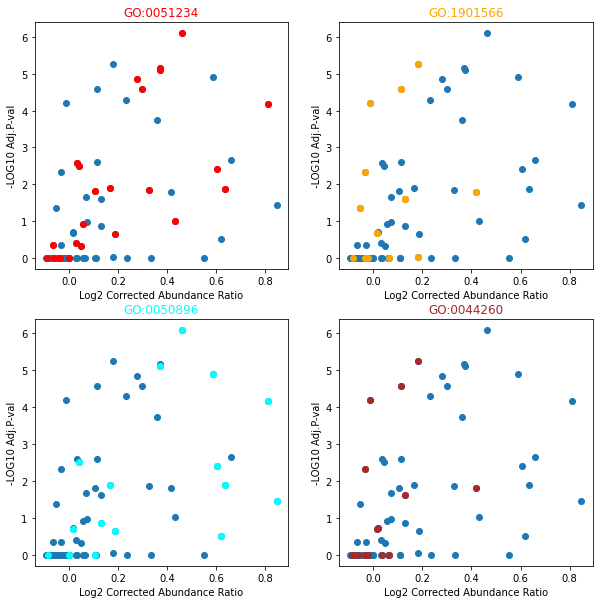

In [155]:
alpha = -0.096
bp = pd.DataFrame(new_data_bp, columns=['p-value', 'description', 'go', 'list of proteines'])
new_data = new_data.loc[new_data["Log2 Corrected Abundance Ratio"]>alpha]   #  les valeurs d'abondance sont celles de la colonne Log2 Corrected Abundance Ratio

fig4, ax4 = plt.subplots(figsize=(10,10), ncols=2, nrows=2) # Générer une grille de 4 graphiques 

# GO:0051234
ax4[0][0].scatter(new_data["Log2 Corrected Abundance Ratio"], new_data["LOG10 Adj.P-val"])
ax4[0][0].set_title('GO:0051234', color='red')
ax4[0][0].set_xlabel("Log2 Corrected Abundance Ratio")
ax4[0][0].set_ylabel("-LOG10 Adj.P-val")
list_id = bp.loc[bp['go']=='GO:0051234']["list of proteines"] 
new_data_prot = new_data.loc[new_data['Accession'].isin(list_id.tolist()[0])]
ax4[0][0].scatter(new_data_prot["Log2 Corrected Abundance Ratio"], new_data_prot["LOG10 Adj.P-val"], color='red')

# GO:1901566
ax4[0][1].scatter(new_data["Log2 Corrected Abundance Ratio"], new_data["LOG10 Adj.P-val"])
ax4[0][1].set_title('GO:1901566', color='orange')
ax4[0][1].set_xlabel("Log2 Corrected Abundance Ratio")
ax4[0][1].set_ylabel("-LOG10 Adj.P-val")
list_id = bp.loc[bp['go']=='GO:1901566']["list of proteines"] 
new_data_prot = new_data.loc[new_data['Accession'].isin(list_id.tolist()[0])]
ax4[0][1].scatter(new_data_prot["Log2 Corrected Abundance Ratio"], new_data_prot["LOG10 Adj.P-val"], color='orange')

# GO:0050896	
ax4[1][0].scatter(new_data["Log2 Corrected Abundance Ratio"], new_data["LOG10 Adj.P-val"])
ax4[1][0].set_title('GO:0050896', color='cyan')
ax4[1][0].set_xlabel("Log2 Corrected Abundance Ratio")
ax4[1][0].set_ylabel("-LOG10 Adj.P-val")
list_id = bp.loc[bp['go']=='GO:0050896']["list of proteines"] 
new_data_prot = new_data.loc[new_data['Accession'].isin(list_id.tolist()[0])]
ax4[1][0].scatter(new_data_prot["Log2 Corrected Abundance Ratio"], new_data_prot["LOG10 Adj.P-val"], color='cyan')

# GO:0044260
ax4[1][1].scatter(new_data["Log2 Corrected Abundance Ratio"], new_data["LOG10 Adj.P-val"])
ax4[1][1].set_title('GO:0044260', color='brown')
ax4[1][1].set_xlabel("Log2 Corrected Abundance Ratio")
ax4[1][1].set_ylabel("-LOG10 Adj.P-val")
list_id = bp.loc[bp['go']=='GO:0044260']["list of proteines"] 
new_data_prot = new_data.loc[new_data['Accession'].isin(list_id.tolist()[0])]
ax4[1][1].scatter(new_data_prot["Log2 Corrected Abundance Ratio"], new_data_prot["LOG10 Adj.P-val"], color='brown')
